In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from utils.streams import Dataset

%matplotlib inline
#%matplotlib qt

plt.style.use('ggplot')


In [2]:
stream_root_folder = r"C:\Users\neurogears\Desktop\EC_datasets\SoundCardTKbenchmark2022_09_27_15_16_36"
dataset = Dataset(stream_root_folder)
dataset.populate_streams(autoload = False)

In [49]:
#Load necessary streams for the test
dataset.streamsMicrophone.Audio.load()
dataset.streamsMicrophone.Audio.data = dataset.streamsMicrophone.Audio.data[:,1]
dataset.streamsMicrophone.BufferIndex.load()

dataset.streamsBioData.Set.load()


In [50]:
#must grab the bufferindex timestamp
fs = 44100
buffer_duration = 10e-3 #in seconds
buffer_length = np.ceil(buffer_duration * fs)
print(buffer_length)

441.0


In [51]:
dataset.streamsMicrophone.BufferIndex.data

,Value
Seconds,
1904-01-01 22:53:04.956000,0
1904-01-01 22:53:04.957984,1
1904-01-01 22:53:04.968000,2
1904-01-01 22:53:04.982976,3
1904-01-01 22:53:04.997984,4
...,...
1904-01-01 23:07:24.126976,85911
1904-01-01 23:07:24.126976,85912
1904-01-01 23:07:24.141984,85913


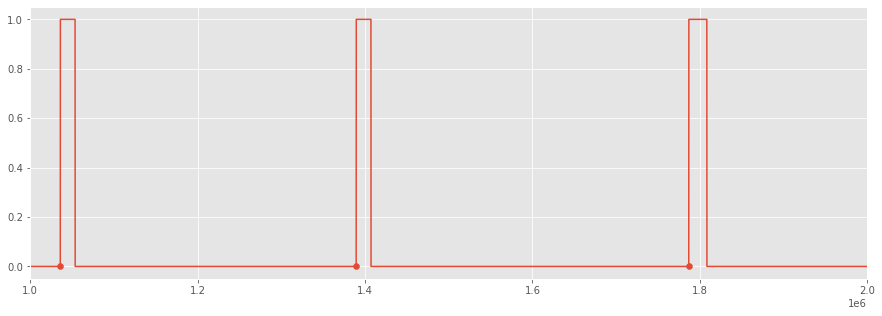

In [52]:
thr = 200

ttl = (dataset.streamsMicrophone.Audio.data > thr).astype(float)
ttl = pd.DataFrame(ttl).rolling(10000).max().values #get rid of double hits due to hysteresis using a max-window filter.
sample_rising_edge = np.where(np.diff(ttl[:,0]) == 1)[0]

plt.figure(figsize=(15,5))
plt.plot(ttl)
plt.scatter(sample_rising_edge, ttl[sample_rising_edge])
plt.xlim((0.1e7, 0.2e7))
plt.show()

In [85]:
def get_buffer_ts(sample, source, buffer_size = 441):
    i = np.floor(sample/buffer_size)
    remainder = sample%buffer_size
    add_time_sec = pd.Timedelta(remainder/fs, 's')
    return source.index[(source == i-1).values[:,0]] + add_time_sec ## subtract one index to correct for the buffer timestamping

buffer_ts = np.array([get_buffer_ts(x, dataset.streamsMicrophone.BufferIndex.data) for x in sample_rising_edge])[:,0]

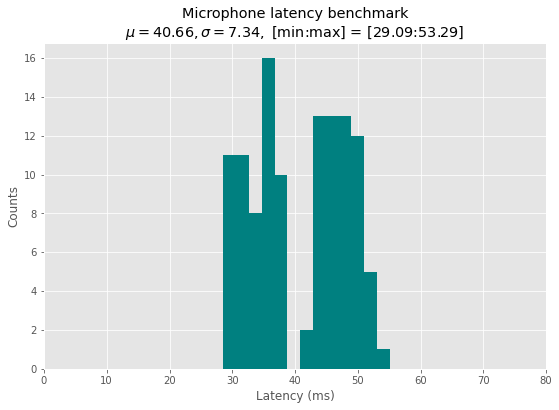

In [87]:
delta_t = - (dataset.streamsBioData.Set.data.index - buffer_ts) / np.timedelta64(1, "ms")

plt.figure(figsize= (9,6))
plt.hist(delta_t, np.linspace(0, 100, 50), color= "Teal")
plt.xlabel('Latency (ms)')
plt.ylabel('Counts')
plt.xlim((0,80))
plt.title(f'Microphone latency benchmark\n$\mu = {np.mean(delta_t):.2f}, \sigma = {np.std(delta_t):.2f},$ [min:max] = [{np.min(delta_t):.2f}:{np.max(delta_t):.2f}]')
plt.show()
